
<center>
<h1> AWS SageMaker </h1>
    <h2>Scalable MLOps using AWS SageMaker </h2>
    <h3>November, 2022</h3>
<hr>
<h1>Exploratory Data Analysis</h1>
<hr>
 </center>

# Introduction
We start our journey into MLOps with AWS SageMaker by inspecting the dataset with regards to:

1. Data composition, with regards to structure and quality
2. Associations between the different attributes

Let´s get started by installing some of the non-default libraries.

In [ ]:
!pip install umap-learn

In [ ]:
!pip install seaborn==0.11.2

In [2]:
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import os
import warnings
warnings.filterwarnings("ignore")

# Connecting to the s3 bucket


<div class="alert alert-info"> 🎯 <strong> Edit S3 bucket name </strong>
    
Replace the bucket name with the name of your bucket. Note that the permissions of the bucket must allow access to the role. In my case, I have given the role full access to the S3 bucket named "aws-sagemaker-blogpost".
</div>


In [2]:
# Paths for the containers that we will create
# S3 Bucket where the data is stored
BUCKET_NAME = "sagemaker-done-mlops"  # Put your S3 bucket name here
BUCKET = f's3://{BUCKET_NAME}'

# Raw data paths
RAW_DATA_FOLDER = 'data'
RAW_DATA_FILE = 'wind_turbines.csv'
RAW_DATA_PATH = os.path.join(BUCKET, RAW_DATA_FOLDER, RAW_DATA_FILE)


df = pd.read_csv(RAW_DATA_PATH)

## 1. Understanding the data composition
we do this by examining:
* dimension, how many rows and columns?
* fraction of missing data
* datatypes of each attribute

### Data dimensions

In [3]:
print(df.shape)

(52383, 16)


We see that we a total of 16 attributes and 52383 rows. Lets next answer how much of the data is missing and what each attribute is composed of.

### Fraction of missing data and datatype per attribute

In [12]:
(pd.DataFrame([df.isna().mean(), df.dtypes, df.nunique()])
   .T
   .rename({0:'fraction of na',
            1:'datatype',
            2:'n_unique_entries'}, axis=1))

,fraction of na,datatype,n_unique_entries
wt_sk,0.0,int64,4
measured_at,0.0,object,13098
wind_speed,0.0,float64,52383
power,0.0,float64,52383
nacelle_direction,0.0,float64,52383
wind_direction,0.0,float64,52383
rotor_speed,0.0,float64,52383
generator_speed,0.0,float64,52383
temp_environment,0.0,float64,52383
temp_hydraulic_oil,0.0,float64,52383


In [ ]:
df['measured_at'].head(1)

With this little breakdown we learn that the data consists of 16 attributes of which 15 are numerical and 1 is a timestamp. There are a total of 52383 entries in this dataset with no missing data across the feature attributes. The columns with missing data are the categories we want to predict. The `subtraction` attribute shows the presence of an error and the `categories_sk` attribute descibes the type of error in more depth. 
Since the aim of this exersice is to showcase this dataset and ultimatly a SageMaker workflow we continue with the `subtraction` attribute and drop the `categories_sk` attribute.

In [ ]:
df.drop("categories_sk", axis=1, inplace=True)

Since this is time series data we wanted to see if the data was homogeniously collected over the time span. Thus we first parsed the `measured_at` column into a machine readable datetime and plotted the number of rows over time.

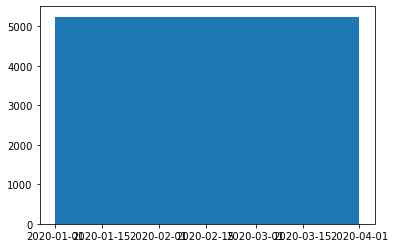

In [15]:
df['measured_at'] = pd.to_datetime(df['measured_at'])

plt.hist(df.measured_at.values)
plt.show()

Great! The data is evenly spread over the sampled time horizon from 2020-01 to 2020-07

Now, lets have a look if, on a high level, we can connect the turbine features with an error type.

# 2. Associations between the different data attributes

Ultimatly we wanted to see the highdimensional structure. We did this by:
   1. z-scoring features excluding the time dimension, turbine number and error code
   2. Collapsing the high dimensional data into 2 dimensions using umap
   3. Highlighting excluded attributes on the 2d representation of the data

/var/folders/g9/c_dttcps3m56h5kkhkdg32wh0000gp/T/ipykernel_23370/2438519670.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_to_plot['error_type'][X_to_plot.error_type.isna()] = 2


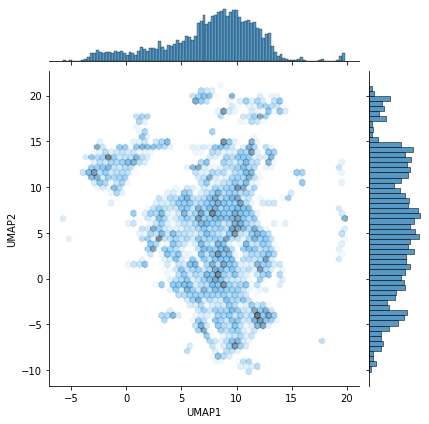

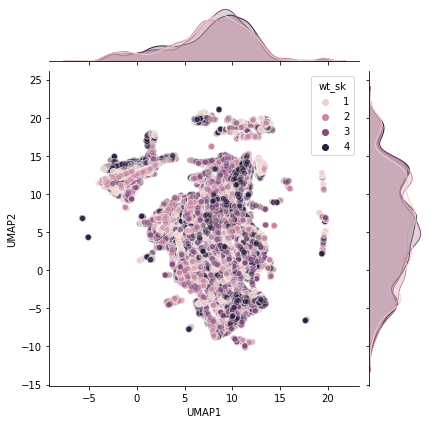

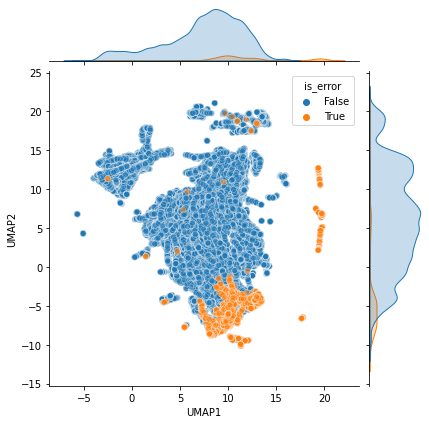

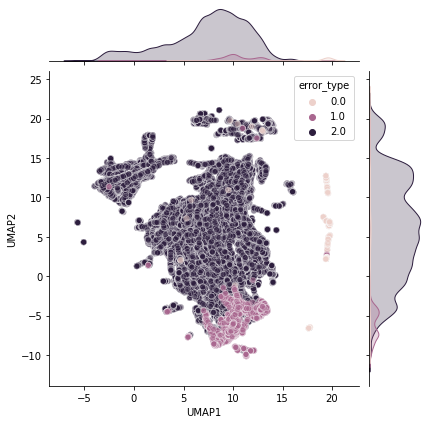

In [17]:
# Split data into labels and features
columns = df.columns.values
y_cols = df.columns.str.contains('wt_sk|subtraction|measured_at')

y = df[list(columns[y_cols])]
X = df[list(columns[~y_cols])]

# 1. Scale features
scaler = StandardScaler()
X_ = scaler.fit_transform(X)

# 2. Get embeddings
embedding = umap.UMAP().fit_transform(X_)

# Curate dataframe for plotting
X_to_plot = pd.DataFrame(embedding, columns=['UMAP1','UMAP2'])
X_to_plot['error_type'] = y['subtraction'].to_list()

# Flag na values with 2 in error type
X_to_plot['error_type'][X_to_plot.error_type.isna()] = 2
X_to_plot['is_error'] = X_to_plot.error_type != 2

X_to_plot = X_to_plot.sort_values(by='is_error', ascending=True)

X_to_plot['wt_sk'] = y['wt_sk'].to_list()

sns.jointplot(data=X_to_plot,
                x='UMAP1',
                y='UMAP2',
                alpha=0.5,
                kind='hex'
)

sns.jointplot(data=X_to_plot,
                x='UMAP1',
                y='UMAP2',
                alpha=0.5,
                hue='wt_sk',
)


sns.jointplot(data=X_to_plot,
                x='UMAP1',
                y='UMAP2',
                alpha=0.5,
                hue='is_error',
)


sns.jointplot(data=X_to_plot,
                x='UMAP1',
                y='UMAP2',
                alpha=0.5,
                hue='error_type',
)

plt.show()

Based on the dimensionality reduction technique we deployed above (we used UMAP) we make the following observations:

1. In the first plot we see that the there is not a single point where most of the data is located but that it is spread across the different dimensions.

2. In the second plot the color indicates the different turbines. Since the colors are equally spread across the dimensions we can assume that there is no strong bias in the data towards one turbine in specific.

3. In the third plot the color indicates wether there is an error or not. We find, as expected, that the errors are mostly located on separated islands with some exceptions where the blue and orange points, corresponding to faulty and working turbines, are mixed.

4. Further looking into the error type we find that the different error types are distinct from each other.

We conclude that we can proceed with training a model on the data


<div class="alert alert-info"> 🎉 <strong> Data looks great! Lets try to model it </strong>

</div>
